## Детали метода fit в Keras

Сегодня обсудим:
1. Как обучаться по батчам (batch_size)
2. Как при обучении считать метрики и на тесте (validation_data)
3. Как обучаться на генераторах
4. И как визуализировать процесс обучения


Получение данных

Описание датасета:

- CRIM     per capita crime rate by town
- ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS    proportion of non-retail business acres per town
- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX      nitric oxides concentration (parts per 10 million)
- RM       average number of rooms per dwelling
- AGE      proportion of owner-occupied units built prior to 1940
- DIS      weighted distances to five Boston employment centres
- RAD      index of accessibility to radial highways
- TAX      full-value property-tax rate per 10,000
- PTRATIO  pupil-teacher ratio by town
- B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT    % lower status of the population
- MEDV     Median value of owner-occupied homes in $1000's

In [1]:
from keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

X_train.shape, X_test.shape

((404, 13), (102, 13))

In [2]:
X_train[:1]

array([[  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
         91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
         18.72   ]])

Масштабирование данных

In [3]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

mean, std

(array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
        5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
        9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
        1.27408168e+01]),
 array([9.22929073e+00, 2.37382770e+01, 6.80287253e+00, 2.40939633e-01,
        1.17147847e-01, 7.08908627e-01, 2.79060634e+01, 2.02770050e+00,
        8.68758849e+00, 1.66168506e+02, 2.19765689e+00, 9.39946015e+01,
        7.24556085e+00]))

In [4]:
X_train -= mean
X_train /= std

X_test -= mean
X_test /= std

In [5]:
X_train.mean(axis=0)

array([-1.01541438e-16,  1.09923072e-17,  1.74337992e-15, -1.26686340e-16,
       -5.25377321e-15,  6.41414864e-15,  2.98441140e-16,  4.94653823e-16,
        1.12671149e-17, -1.98136337e-16,  2.36686358e-14,  5.95679996e-15,
        6.13920356e-16])

In [6]:
X_train.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
X_train.shape

(404, 13)

### Архитектура сети


Определение сети через класс Sequential и добавление слоев в него через add

In [8]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(9)


model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1], )))
model.add(Dense(128, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 38,561
Trainable params: 38,561
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

### Обучение сети

In [10]:
%%time

num_epochs = 100

model.fit(X_train, y_train,
          epochs=num_epochs)

Epoch 1/100
13/13 [==============================] - 1s 4ms/step - loss: 531.2217 - mae: 21.0541
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 345.5101 - mae: 16.1452
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 108.5693 - mae: 8.2144
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 52.7582 - mae: 5.5726
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 27.4220 - mae: 3.6859
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 20.8373 - mae: 3.1989
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 18.8427 - mae: 3.1006
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 16.5789 - mae: 2.8524
Epoch 9/100
13/13 [==============================] - 0s 2ms/step - loss: 15.2218 - mae: 2.7524
Epoch 10/100
13/13 [==============================] - 0s 2ms/step - loss: 14.0879 - mae: 2.6576
Epoch 11/100
13/13 [========================

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nТочность на тестовых данных:", test_acc)

4/4 - 0s - loss: 12.9750 - mae: 2.5086 - 201ms/epoch - 50ms/step

Точность на тестовых данных: 2.508575201034546


Сейчас прошло 13 батчей через сеть

#### **batch_size**
> batch_size: Integer или None.<br>
Количество сэмплов за один шаг градиентного спуска<br>
Если None, то batch_size примет дефолтное значение 32<br>
Не указывайте batch_size, если ваши данные представлены в виде генератора или keras.utils.Sequence (из-за того, что они сами генерируют данные батчами)

In [11]:
X_train.shape

(404, 13)

In [15]:
404 / 32

12.625

<img src='https://drive.google.com/uc?export=view&id=1j8SxKYEi12jzJXi_bPO28q5SV9emuu0Y'>

In [16]:
%%time
num_epochs = 10

model.fit(X_train, y_train,
          epochs=num_epochs,
          batch_size=64)

Epoch 1/10
1/7 [===>..........................] - ETA: 0s - loss: 11.5362 - mae: 2.1041

7/7 [==============================] - 0s 2ms/step - loss: 5.5365 - mae: 1.6563
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 5.5024 - mae: 1.6502
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 5.5291 - mae: 1.6455
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 5.5026 - mae: 1.6339
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 5.4736 - mae: 1.6314
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 5.4676 - mae: 1.6356
Epoch 7/10
7/7 [==============================] - 0s 7ms/step - loss: 5.5055 - mae: 1.6454
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 5.4512 - mae: 1.6399
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 5.4579 - mae: 1.6388
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 5.4648 - mae: 1.6373
CPU times: total: 250 ms
Wall time: 262 ms


In [ ]:
404 / 64

6.3125

In [ ]:
%%time
num_epochs = 10

model.fit(X_train, y_train,
          epochs=num_epochs,
          batch_size=404)

Epoch 1/10
1/1 [==============================] - 0s 183ms/step - loss: 68.9849 - mae: 6.0634
Epoch 2/10
1/1 [==============================] - 0s 14ms/step - loss: 68.2099 - mae: 6.0216
Epoch 3/10
1/1 [==============================] - 0s 11ms/step - loss: 67.4433 - mae: 5.9807
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 66.6846 - mae: 5.9404
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 65.9333 - mae: 5.9007
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 65.1889 - mae: 5.8613
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 64.4519 - mae: 5.8223
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 63.7225 - mae: 5.7836
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 63.0009 - mae: 5.7454
Epoch 10/10
1/1 [==============================] - 0s 6ms/step - loss: 62.2875 - mae: 5.7079
CPU times: user 331 ms, sys: 8.28 ms, total: 339 ms
Wall time: 342 ms


#### **steps_per_epoch**

>  steps_per_epoch: Integer or `None`.<br>
        Общее количество шагов (батчей сэмплов) на одной эпохе. <br>
        Если стоит None, то steps_per_epoch равняется количеству сэмплов в датасете деленное на batch size

In [ ]:
404 / 10

40.4

In [ ]:
%%time
num_epochs = 10

model.fit(X_train, y_train,
          epochs=num_epochs,
          steps_per_epoch=10)

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 58.5746 - mae: 5.5218
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 52.8691 - mae: 5.2081
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 47.0966 - mae: 4.9088
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 43.0253 - mae: 4.6953
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 39.3765 - mae: 4.4933
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 36.2800 - mae: 4.3142
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 33.6417 - mae: 4.1737
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 31.5410 - mae: 4.0545
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 29.8779 - mae: 3.9553
Epoch 10/10
10/10 [==============================] - 0s 2ms/step - loss: 28.2445 - mae: 3.8496
CPU times: user 327 ms, sys: 24.5 ms, total: 351 ms
Wall ti

#### **validation_split**

> validation_split: Float между 0 и 1.<br>
        Доля обучающих данных, которая будет использоваться как валидационная часть<br>
        Модель возьмет эту долю и не будет на ней обучаться, а будет подсчитывать метрики и функцию потерь в конце каждой эпохи<br>
        Данные для валидации берутся из данных с конца в `x` и `y` **до перемешивания**.

In [ ]:
404 - 81

323

In [ ]:
%%time
num_epochs = 10

model.fit(X_train, y_train,
          epochs=num_epochs,
          batch_size=1,
          validation_split=0.2)

Epoch 1/10
323/323 [==============================] - 1s 3ms/step - loss: 23.7887 - mae: 3.4618 - val_loss: 22.3951 - val_mae: 3.4461
Epoch 2/10
323/323 [==============================] - 1s 2ms/step - loss: 18.3039 - mae: 3.0675 - val_loss: 18.8717 - val_mae: 3.1509
Epoch 3/10
323/323 [==============================] - 1s 3ms/step - loss: 15.8008 - mae: 2.7966 - val_loss: 19.4543 - val_mae: 3.3434
Epoch 4/10
323/323 [==============================] - 1s 3ms/step - loss: 13.8707 - mae: 2.6303 - val_loss: 16.4949 - val_mae: 3.0323
Epoch 5/10
323/323 [==============================] - 1s 3ms/step - loss: 12.9570 - mae: 2.4865 - val_loss: 15.5677 - val_mae: 2.8850
Epoch 6/10
323/323 [==============================] - 1s 3ms/step - loss: 11.7685 - mae: 2.3840 - val_loss: 16.9575 - val_mae: 2.7447
Epoch 7/10
323/323 [==============================] - 1s 2ms/step - loss: 11.1454 - mae: 2.3930 - val_loss: 14.1790 - val_mae: 2.6787
Epoch 8/10
323/323 [==============================] - 1s 2ms/s

#### **validation_data**

> validation_data: Данные, на которых считается функция потерь и метрики в конце каждой эпохи<br>
Модель не будет обучаться на этих данных


In [ ]:
%%time
num_epochs = 10

model.fit(X_train, y_train,
          epochs=num_epochs,
          batch_size=1,
          validation_data=(X_test, y_test))

Epoch 1/10
404/404 [==============================] - 1s 2ms/step - loss: 10.6234 - mae: 2.2634 - val_loss: 22.9307 - val_mae: 2.9804
Epoch 2/10
404/404 [==============================] - 1s 2ms/step - loss: 10.3111 - mae: 2.2410 - val_loss: 22.5022 - val_mae: 3.0728
Epoch 3/10
404/404 [==============================] - 1s 2ms/step - loss: 9.8253 - mae: 2.2548 - val_loss: 24.5678 - val_mae: 2.9912
Epoch 4/10
404/404 [==============================] - 1s 2ms/step - loss: 9.7436 - mae: 2.2245 - val_loss: 26.1471 - val_mae: 3.1539
Epoch 5/10
404/404 [==============================] - 1s 2ms/step - loss: 9.3499 - mae: 2.1764 - val_loss: 22.1797 - val_mae: 2.9892
Epoch 6/10
404/404 [==============================] - 1s 2ms/step - loss: 8.9368 - mae: 2.1157 - val_loss: 22.1921 - val_mae: 2.8944
Epoch 7/10
404/404 [==============================] - 1s 2ms/step - loss: 8.7185 - mae: 2.1304 - val_loss: 23.7712 - val_mae: 2.9776
Epoch 8/10
404/404 [==============================] - 1s 2ms/step -

#### **validation_batch_size**

>validation_batch_size: Integer или `None`.<br>
        Количество сэмплов в один валидационный батч<br>
        Если None, то по дефолту равняется `batch_size`.<br>
        Не указывайте `validation_batch_size`, если ваши данные представлены в виде генератора или keras.utils.Sequence (из-за того, что они сами генерируют данные батчами)

In [ ]:
X_test.shape

(102, 13)

In [ ]:
%%time
num_epochs = 10

model.fit(X_train, y_train,
          epochs=num_epochs,
          batch_size=1,
          validation_data=(X_test, y_test),
          validation_batch_size=X_test.shape[0])

Epoch 1/10
404/404 [==============================] - 1s 2ms/step - loss: 7.2319 - mae: 1.9065 - val_loss: 18.4802 - val_mae: 2.6468
Epoch 2/10
404/404 [==============================] - 1s 2ms/step - loss: 7.3097 - mae: 1.9392 - val_loss: 19.0097 - val_mae: 2.6813
Epoch 3/10
404/404 [==============================] - 1s 2ms/step - loss: 6.9716 - mae: 1.9379 - val_loss: 20.7965 - val_mae: 2.7282
Epoch 4/10
404/404 [==============================] - 1s 2ms/step - loss: 7.2285 - mae: 1.9399 - val_loss: 22.9594 - val_mae: 2.9067
Epoch 5/10
404/404 [==============================] - 1s 2ms/step - loss: 7.0538 - mae: 1.9161 - val_loss: 18.5269 - val_mae: 2.7269
Epoch 6/10
404/404 [==============================] - 2s 4ms/step - loss: 6.9260 - mae: 1.9017 - val_loss: 18.7155 - val_mae: 2.6446
Epoch 7/10
404/404 [==============================] - 1s 3ms/step - loss: 6.5769 - mae: 1.8571 - val_loss: 21.4642 - val_mae: 2.8613
Epoch 8/10
404/404 [==============================] - 1s 2ms/step - l

#### **validation_freq**
>validation_freq: Только нужен, если предоставлены validation data. Integer
        или `collections.abc.Container` (например, list, tuple, и др.).<br>
        Если integer, то столько эпох с обучением пройдет, до одной валидации, например, `validation_freq=2` будет запускать валидацию каждые 2 эпохи.<br>
        Если это Container, то валидация будет запущена в эти эпохи, к примеру,`validation_freq=[1, 2, 10]` запускает валидацию на 1, 2 и 10 эпохах.

In [12]:
%%time
num_epochs = 200

model.fit(X_train, y_train,
          epochs=num_epochs,
          batch_size=1,
          validation_data=(X_test, y_test),
          validation_batch_size=X_test.shape[0],
          validation_freq=3)

Epoch 1/200
  1/404 [..............................] - ETA: 2s - loss: 1.3375 - mae: 1.1565

404/404 [==============================] - 1s 2ms/step - loss: 8.6601 - mae: 2.2287
Epoch 2/200
404/404 [==============================] - 1s 2ms/step - loss: 9.1808 - mae: 2.2719
Epoch 3/200
404/404 [==============================] - 1s 2ms/step - loss: 8.4288 - mae: 2.1259 - val_loss: 22.8982 - val_mae: 3.1228
Epoch 4/200
404/404 [==============================] - 1s 2ms/step - loss: 8.7320 - mae: 2.1880
Epoch 5/200
404/404 [==============================] - 1s 2ms/step - loss: 8.1617 - mae: 2.1176
Epoch 6/200
404/404 [==============================] - 1s 2ms/step - loss: 8.6938 - mae: 2.1331 - val_loss: 18.4184 - val_mae: 2.6647
Epoch 7/200
404/404 [==============================] - 1s 1ms/step - loss: 7.4333 - mae: 2.0237
Epoch 8/200
404/404 [==============================] - 1s 2ms/step - loss: 8.0074 - mae: 2.0284
Epoch 9/200
404/404 [==============================] - 1s 2ms/step - loss: 7.5995 - mae: 1.9902 - val_loss: 29.5300 - val_mae: 3.9697
Epoch 10/200
404/404 [============

In [13]:
X_test[:1]

array([[ 1.55369355, -0.48361547,  1.0283258 , -0.25683275,  1.03838067,
         0.23545815,  1.11048828, -0.93976936,  1.67588577,  1.5652875 ,
         0.78447637, -3.48459553,  2.25092074]])

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nТочность на тестовых данных:", test_acc)

4/4 - 0s - loss: 11.3455 - mae: 2.3379 - 130ms/epoch - 33ms/step

Точность на тестовых данных: 2.337899684906006


In [19]:
%%time
num_epochs = 10

model.fit(X_train, y_train,
          epochs=num_epochs,
          batch_size=1,
          validation_data=(X_test, y_test),
          validation_batch_size=X_test.shape[0],
          validation_freq=[1, 5, 10])

Epoch 1/10
  1/404 [..............................] - ETA: 1s - loss: 0.0110 - mae: 0.1050

404/404 [==============================] - 1s 1ms/step - loss: 4.9710 - mae: 1.6048 - val_loss: 15.2396 - val_mae: 2.6089
Epoch 2/10
404/404 [==============================] - 1s 1ms/step - loss: 5.0176 - mae: 1.6145
Epoch 3/10
404/404 [==============================] - 0s 1ms/step - loss: 4.9220 - mae: 1.6063
Epoch 4/10
404/404 [==============================] - 0s 1ms/step - loss: 4.9822 - mae: 1.6141
Epoch 5/10
404/404 [==============================] - 1s 1ms/step - loss: 4.9541 - mae: 1.6030 - val_loss: 15.1405 - val_mae: 2.5967
Epoch 6/10
404/404 [==============================] - 1s 1ms/step - loss: 4.8023 - mae: 1.5789
Epoch 7/10
404/404 [==============================] - 0s 1ms/step - loss: 4.4968 - mae: 1.5338
Epoch 8/10
404/404 [==============================] - 0s 1ms/step - loss: 4.7522 - mae: 1.5871
Epoch 9/10
404/404 [==============================] - 1s 1ms/step - loss: 4.5943 - mae: 1.5386
Epoch 10/10
404/404 [==============================] - 1s 1ms/step - loss: 4.598

### Обучение нейросети на генераторах

Про Sequence больше [тут](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=32):
        self.batch_size = batch_size
        self.data = data
        self.labels = labels

    def __len__(self):
        return int(np.round(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        X = self.data[index * self.batch_size : (index+1) * self.batch_size]
        y = self.labels[index * self.batch_size : (index+1) * self.batch_size]

        return X, y

In [ ]:
train_datagen = DataGenerator(X_train, y_train)
test_datagen = DataGenerator(X_test, y_test)

In [ ]:
len(train_datagen)

13

In [ ]:
len(test_datagen)

3

In [ ]:
for X, y in train_datagen:
    print(X.shape)
    print(y.shape)
    break

(32, 13)
(32,)


In [ ]:
404 / 32

12.625

In [ ]:
%%time
num_epochs = 10

model.fit(train_datagen,
          epochs=num_epochs,
          validation_data=test_datagen)

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 4.3028 - mae: 1.5017 - val_loss: 10.6313 - val_mae: 2.3160
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 4.2798 - mae: 1.5001 - val_loss: 10.5893 - val_mae: 2.3111
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 4.2795 - mae: 1.5009 - val_loss: 10.5323 - val_mae: 2.3027
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 4.2758 - mae: 1.5027 - val_loss: 10.5573 - val_mae: 2.3057
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 4.2753 - mae: 1.5022 - val_loss: 10.6443 - val_mae: 2.3170
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 4.2678 - mae: 1.4992 - val_loss: 10.6279 - val_mae: 2.3156
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 4.2676 - mae: 1.4984 - val_loss: 10.5898 - val_mae: 2.3081
Epoch 8/10
13/13 [==============================] - 0s 6ms/step - loss: 4.2700 - m

### History

Больше [тут](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)

In [ ]:
%%time
num_epochs = 10

history = model.fit(train_datagen,
                    epochs=num_epochs,
                    validation_data=test_datagen)

Epoch 1/10
13/13 [==============================] - 1s 29ms/step - loss: 567.5922 - mae: 21.9870 - val_loss: 560.5504 - val_mae: 21.9396
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 547.6655 - mae: 21.5061 - val_loss: 539.8265 - val_mae: 21.4437
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 525.2613 - mae: 20.9650 - val_loss: 516.1148 - val_mae: 20.8650
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 499.9608 - mae: 20.3316 - val_loss: 488.0100 - val_mae: 20.1525
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 469.9943 - mae: 19.5615 - val_loss: 454.7536 - val_mae: 19.2809
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 435.0141 - mae: 18.6295 - val_loss: 416.6180 - val_mae: 18.2459
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 394.4474 - mae: 17.5131 - val_loss: 374.2877 - val_mae: 17.1353
Epoch 8/10
13/13 [=============================

In [ ]:
history

In [ ]:
history.history

{'loss': [567.5922241210938,
  547.6654663085938,
  525.2612915039062,
  499.96075439453125,
  469.99432373046875,
  435.0141296386719,
  394.4473571777344,
  350.4708251953125,
  301.77166748046875,
  250.4050750732422],
 'mae': [21.987014770507812,
  21.506057739257812,
  20.965007781982422,
  20.331594467163086,
  19.561542510986328,
  18.629533767700195,
  17.5130615234375,
  16.290931701660156,
  14.853785514831543,
  13.216885566711426],
 'val_loss': [560.5504150390625,
  539.8264770507812,
  516.1148071289062,
  488.010009765625,
  454.7536315917969,
  416.6179504394531,
  374.2876892089844,
  326.7027282714844,
  276.3855895996094,
  222.0868682861328],
 'val_mae': [21.939577102661133,
  21.443740844726562,
  20.864990234375,
  20.152509689331055,
  19.28089714050293,
  18.245872497558594,
  17.135271072387695,
  15.900837898254395,
  14.517024993896484,
  12.851500511169434]}

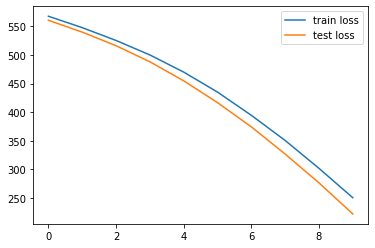

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

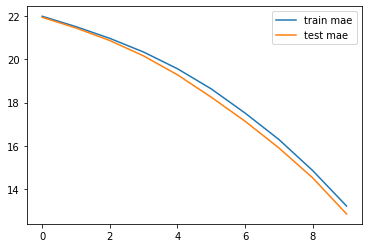

In [ ]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='test mae')
plt.legend();

History - Callback, про них поговорим в следующих занятиях

## Summary


Вот мы и разобрались в деталях, что можно передавать в метод fit в Keras.

**batch size**

<img src='https://miro.medium.com/max/1400/1*jig1e2BDLN7KPmgOcirflQ.jpeg' width=500>

___________________

**steps_per_epoch**

<img src='https://media4.giphy.com/media/FMAUcALBqjajXV0qej/giphy.gif?cid=ecf05e47xa7bnffmbiq333qb36btdm8a262ww7xbgyu6ti2t&rid=giphy.gif&ct=g'>

___________________

**validation_split**

<img src='https://media2.giphy.com/media/D2cY6SySBjyBuOzsYq/giphy.gif?cid=ecf05e47triw0wubv3aubehd4enhcus9dlxr996xnss8uffg&rid=giphy.gif&ct=g'>

___________________

**validation_data** и **validation_batch_size**

<img src='https://media0.giphy.com/media/yOhgNO9YsmdsQ/giphy.gif?cid=ecf05e473qx1a618m4t3o922udc1mcfmqtfwdyi4mrqg2gcf&rid=giphy.gif&ct=g'>

___________________

**validation_freq**

<img src='http://memecrunch.com/meme/BH6DD/whats-the-frequency/image.jpg'>

___________________

**Обучение нейросети на генераторах**

<img src='https://realprodom.com/images/cat-proger.gif'>

___________________

**Callback History**

<img src='https://drive.google.com/uc?id=1BxyC2qbNFgavqzCDQPj_sSuHYrjQHfNy' width=400>


**Муррр** ♥